The basic steps we'll take are:

Use DuckDuckGo to search for images of "bird photos"
Use DuckDuckGo to search for images of "forest photos"
Fine-tune a pretrained neural network to recognise these two groups
Try running this model on a picture of a bird and see if it works.


Imports

In [4]:
# Forzamos un backend de Matplotlib compatible para este entorno
import matplotlib as plt
plt.use("TkAgg")

# Herramientas de busqueda (DuckDuckGo) y utilidades de vision de fastai
from ddgs import DDGS

from fastdownload import download_url
from fastai.vision.all import *

Download the images from DGGS (Duck go go searcher)

In [5]:
def search_images(keywords, max_images=5):
    """Consulta DuckDuckGo y devuelve URLs directas de imagenes."""
    with DDGS() as ddgs:
        results = ddgs.images(
            keywords,
            max_results=max_images
        )
        return [r["image"] for r in results]

# Ejemplo rapido: obtenemos algunas fotos de aves para explorar los datos
urls = search_images("bird photos", max_images=2)
print(urls[0])

https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg


In [6]:

# Descargamos una de las imagenes de ejemplo para inspeccionarla
dest = 'bird.jpg'
download_url(urls[1], dest, show_progress=True)


Path('bird.jpg')

Download the image and 

In [7]:
# Exploramos transformaciones rapidas sobre la imagen descargada
im = PILImage.create(dest)
im.to_thumb(256,256).show()      # thumbnail
(im.flip_lr()).show()            # voltear horizontal
(im.rotate(30)).show()           # rotacion ligera

im.shape  # dimensiones originales



(2832, 4256)

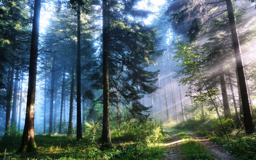

In [8]:
# Guardamos una imagen de bosque para usarla como ejemplo negativo
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [9]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

DataBlock es una manera flexible de definir cómo quieres preparar tus datos. Es como una receta que le dice a fastai: Qué tipo de datos estás usando (imágenes, etiquetas, texto, etc.). Cómo obtenerlos. Cómo dividirlos en entrenamiento y validación. Cómo transformarlos.

1️⃣ blocks=(ImageBlock, CategoryBlock)

    Esto le dice a fastai:

    ImageBlock: las entradas (X) son imágenes.

    CategoryBlock: las salidas (Y) son categorías (por ejemplo, "perro", "gato", "bosque", etc.).

2️⃣ get_items=get_image_files

    Esto le dice a fastai cómo obtener las imágenes desde el directorio que le pases más adelante (path).

    get_image_files busca todos los archivos de imagen (.jpg, .png, etc.) dentro del directorio y sus subcarpetas.

3️⃣ splitter=RandomSplitter(valid_pct=0.2, seed=42)

    Esto define cómo se divide tu conjunto de datos en:

    Entrenamiento (80%)

    Validación (20%)

    🔹 valid_pct=0.2 → usa el 20% de las imágenes para validación.
    🔹 seed=42 → asegura que la división sea siempre igual (útil para reproducir resultados).

    💡 La validación sirve para evaluar cómo de bien generaliza tu modelo con datos que no ha visto durante el entrenamiento.

4️⃣ get_y=parent_label

    Esto le dice a fastai cómo obtener la etiqueta (Y) de cada imagen.

    🗂️ parent_label significa que la etiqueta es el nombre de la carpeta donde está la imagen.
    
5️⃣ item_tfms=[Resize(192, method='squish')]

    El comando item_tfms=[Resize(192, method='squish')] está redimensionando todas las imágenes a un tamaño fijo de 192x192 píxeles, deformándolas si es necesario para que encajen exactamente en ese tamaño(squish). Esto se hace porque los modelos de deep learning necesitan que todas las imágenes tengan el mismo tamaño para poder procesarlas en lotes de manera eficiente y sin errores. Redimensionar también reduce la carga computacional, haciendo el entrenamiento más rápido y manejable.


Un DataLoader es un objeto que contiene el conjunto de datos ya preparado (imágenes + etiquetas), listo para ser:
Entregado al modelo por lotes (batches).
Con las transformaciones aplicadas (como Resize).
Y dividido en entrenamiento y validación.

In [11]:
# Imprime esto para verificar
print(path)
print(list(path.ls()))

bird_or_not
[Path('bird_or_not/bird'), Path('bird_or_not/forest')]


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

ValueError: This DataLoader does not contain any batches

In [28]:
# Creamos un modelo vision_learner con resnet18 y lo afinamos sobre nuestro dataset
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)  # entrenamos 3 epocas


epoch,train_loss,valid_loss,error_rate,time
0,nan,2.745109,0.500000,00:00


c:\Users\tonid\Desktop\jupiter_notebook\langraph_test\.venv\Lib\site-packages\fastprogress\fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,error_rate,time
0,nan,2.745109,0.500000,00:00
1,nan,2.745109,0.500000,00:00
2,nan,2.745109,0.500000,00:00


In [ ]:
# Evaluamos el modelo con una imagen de bosque preparada antes
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")


This is a: bird.
Probability it's a bird: 0.9993
